## 迁移学习教程
事实上, 很少有人从头(随机初始化)开始训练一个卷积网络, 因为拥有一个足够大的数据库是比较少见的. 替代的是, 通常会从一个大的数据集(例如 ImageNet, 包含120万的图片和1000个分类)预训练一个卷积神经网络, 这个预训练的卷积神经网络, 要不是作为初始化的网络, 就是作为感兴趣任务的固定的特征提取器.

如下是两种主要的迁移学习的使用场景:

* 微调卷积神经网络: 取代随机初始化网络, 我们从一个预训练的网络初始化, 比如从 imagenet 1000 数据集预训练的网络. 其余的训练就像往常一样.
* 卷积神经网络作为固定的特征提取器: 在这里, 我们固定网络中的所有权重, 最后的全连接层除外. 最后的全连接层被新的随机权重替换, 并且, 只有这一层是被训练的.

In [1]:
# license : BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function,division

import torch
import torch.nn as nn
import torch.optim as optim
#   from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time 
import os 
import copy

plt.ion()

In [2]:
#训练一个用于区分ants 和 bees的模型
#验证只做数据标准化

data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'hymenoptera_data'
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()


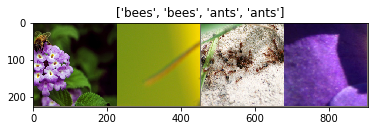

In [3]:
#显示一些图片
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 暂停一伙, 让 plots 更新


# 获得一批训练数据
inputs, classes = next(iter(dataloaders['train']))

# 从那批数据生成一个方格
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 训练模型
现在让我们写一个通用的函数来训练模型，在这里，我们要做一个简要的说明。
* 调度学习率
* 保存最好的学习模型

In [4]:
#scheduler 参数是 torch.optim.lr_scheduler 中的 LR scheduler 对象.

def train_modle(model,criterion,optimizer,scheduler,num_epochs = 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs -1))
        print('-' * 10)
        
        #每一个迭代都有训练和验证阶段
        for phase in ['train','val']:
            if phase == 'train':
                schedule.step()
                model.train(True)    #设置 model 为训练模式
            else:
                model.train(False)
            
            running_loss = 0.0
            runing_corrects = 0.0
            
            #遍历数据
            for data in dataloaders[phase]:
                #获取输入
                inputs, labels = data
                
                #用 Variable 包装输入数据
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                    
                else:
                    inputs,labels = Variable(inputs),Variable(labels)
                    
                #设置梯度参数为0
                optimizer.zero_grad()
                
                #正向传播
                outputs = model(inputs)
                _, preds = torch.max(outputs.data,1)
                loss = criterion(outputs,labels)
                
                #如果是训练阶段，向后传递优化
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                #统计
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
                    
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # 深拷贝 model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最好模型的权重
    model.load_state_dict(best_model_wts)
    return model



### 显示模型的预测结果
写一个处理少量图片，并显示预测结果的通用函数

In [5]:
def visualize_model(model,num_images = 6):
    images_so_far = 0.0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        
        else:
            inputs,labels = Variable(inputs),Variable(labels)
            
        outputs = model(inputs)
        _,preds = torch.max(outputs.data,1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return
                 

### 调整卷积网络
加载一个预训练的网络，并重置最后一个全链接层

In [6]:
"""
model_ft =models.resnet18(pretrained  =True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)

if torch.cuda.is_available():
    model_ft = model_ft.cuda()
    
#交叉熵
criterion = nn.CrossEntropyLoss()

#如你所见，所有的参数都将会被优化
optimizer_ft = optim.SGD(model_ft.paramters(),lr = 0.001,momentum = 0.9)

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

#visualize_model(model_ft)
"""

'\nmodel_ft =models.resnet18(pretrained  =True)\nnum_ftrs = model_ft.fc.in_features\nmodel_ft.fc = nn.Linear(num_ftrs,2)\n\nif torch.cuda.is_available():\n    model_ft = model_ft.cuda()\n    \n#交叉熵\ncriterion = nn.CrossEntropyLoss()\n\n#如你所见，所有的参数都将会被优化\noptimizer_ft = optim.SGD(model_ft.paramters(),lr = 0.001,momentum = 0.9)\n\n#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)\n#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,\n                       num_epochs=25)\n\n#visualize_model(model_ft)\n'

### 卷积网络作为固定的特征提取器

这里，我们固定网络中除最后一层外的是所有权重，为了固定这些参数，我们需要设置requires_grad == False , 然后在 backward() 中就不会计算梯度.

In [7]:

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 新构建的 module 的参数中, 默认设置了 requires_grad=True.
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# 如你所见, 和我们前面提出的一样, 只有最后一层的参数被优化.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 每 7 个迭代, 让 LR 衰减 0.1 因素
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

visualize_model(model_conv)

plt.ioff()
plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\cpf/.torch\models\resnet18-5c106cde.pth
0.6%


TimeoutError: [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。